In [1]:
%matplotlib inline

import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

from lstm_utils import get_raw_data
from lstm_utils import get_seq_model
from lstm_utils import get_seq_train_test
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_squared_error

Using Theano backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Set Parameters

In [3]:
TRAIN_PERCENT = 0.7
STOCK_INDEX = '^GSPC'
VERBOSE=True

## Getting Data

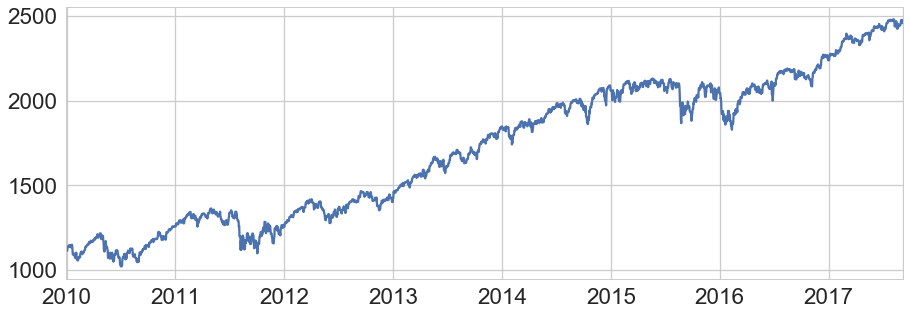

In [4]:
sp_df = get_raw_data(STOCK_INDEX)
sp_close_series = sp_df.Close 

sp_close_series.plot()

## Preprocessing Data

In [5]:
# split train and test datasets
train,test,scaler = get_seq_train_test(sp_close_series,
                                   scaling=True,
                                   train_size=TRAIN_PERCENT)

train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 1965, 1)
train_y shape=(1, 1965, 1)
test_x shape=(1, 842, 1)
test_y shape=(1, 842, 1)


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda2\envs\python3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


## Prepare LSTM Model

In [6]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),
                                                verbose=VERBOSE)   
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(input_shape=(train_x.shape[1],1),
                                                verbose=VERBOSE)

Model Build Failed. Trying Again
> Compilation Time :  0.008561372756958008
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1965, 4)           96        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1965, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


## Fit the Model

In [7]:
# train the model
seq_lstm_model.fit(train_x, train_y, 
               epochs=150, batch_size=1, 
               verbose=2)
print("Model Fit Complete")

Epoch 1/150
0s - loss: 0.1923
Epoch 2/150
0s - loss: 0.1838
Epoch 3/150
0s - loss: 0.1781
Epoch 4/150
0s - loss: 0.1734
Epoch 5/150
0s - loss: 0.1694
Epoch 6/150
0s - loss: 0.1658
Epoch 7/150
0s - loss: 0.1625
Epoch 8/150
0s - loss: 0.1593
Epoch 9/150
0s - loss: 0.1564
Epoch 10/150
0s - loss: 0.1535
Epoch 11/150
0s - loss: 0.1507
Epoch 12/150
0s - loss: 0.1479
Epoch 13/150
0s - loss: 0.1452
Epoch 14/150
0s - loss: 0.1426
Epoch 15/150
0s - loss: 0.1399
Epoch 16/150
0s - loss: 0.1373
Epoch 17/150
0s - loss: 0.1346
Epoch 18/150
0s - loss: 0.1320
Epoch 19/150
0s - loss: 0.1294
Epoch 20/150
0s - loss: 0.1267
Epoch 21/150
0s - loss: 0.1241
Epoch 22/150
0s - loss: 0.1214
Epoch 23/150
0s - loss: 0.1188
Epoch 24/150
0s - loss: 0.1162
Epoch 25/150
0s - loss: 0.1135
Epoch 26/150
0s - loss: 0.1109
Epoch 27/150
0s - loss: 0.1083
Epoch 28/150
0s - loss: 0.1056
Epoch 29/150
0s - loss: 0.1030
Epoch 30/150
0s - loss: 0.1004
Epoch 31/150
0s - loss: 0.0978
Epoch 32/150
0s - loss: 0.0952
Epoch 33/150
0s -

## Train Prediction Performance

In [8]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.02 RMSE


## Test Prediction Performance

In [9]:
# Pad input sequence
testPredict = pad_sequences(test_x,
                                maxlen=train_x.shape[1],
                                padding='post',
                                dtype='float64')

In [10]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

# evaluate performances
testScore = math.sqrt(mean_squared_error(test_y[0], 
                                         testPredict[0][:test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.07 RMSE


## Plot Test Predictions

In [11]:
# inverse transformation
trainPredict = scaler.inverse_transform(trainPredict.\
                                        reshape(trainPredict.shape[1]))
testPredict = scaler.inverse_transform(testPredict.\
                                       reshape(testPredict.shape[1]))

C:\Anaconda2\envs\python3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda2\envs\python3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


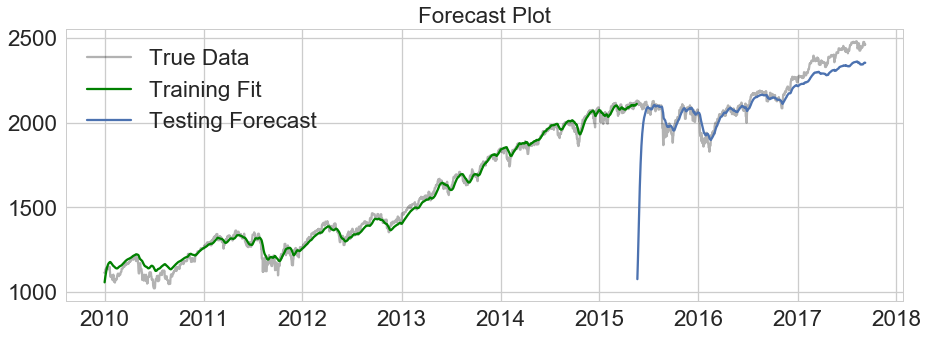

In [12]:
# plot the true and forecasted values
train_size = len(trainPredict)+1

plt.plot(sp_close_series.index,
         sp_close_series.values,c='black',
         alpha=0.3,label='True Data')
plt.plot(sp_close_series.index[1:train_size],
         trainPredict,label='Training Fit',c='g')
plt.plot(sp_close_series.index[train_size+1:],
         testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()